# 03 - Model & Evaluation

This notebook trains and compares several regression models to predict the RUL (Remaining Useful Life) of aircraft engines from the CMAPSS FD001 dataset.

## Methodology

We follow a standard progression with increasing model complexity

Baseline -> Linear Regression -> Random Forest -> XGBoost

For Random Forest and XGBoost, we first perform top feature selection based on feature importance before optimizing hyperparameters using GridSearchCV.

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
import joblib
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from src.config import (
    RANDOM_STATE,
    TOP_FEATURES, 
    N_SPLITS, 
    DATA_PROCESSED,
    OUTPUTS_PLOTS,
    OUTPUTS_MODELS,
    DATASET,
    ROOT,
    DATA_RAW,
    CLIP_RUL
)
from src.model import (
    split_by_unit,
    prepare_data,
    Baseline,
    plot_importance,
    select_top_features,
    run_experiment
)

from src.preprocessing import (
    remove_low_variance_features, 
    add_features
)

OUTPUTS_PLOTS.mkdir(parents=True, exist_ok=True)
OUTPUTS_MODELS.mkdir(parents=True, exist_ok=True)

In [2]:
# best_rf  = joblib.load(OUTPUTS_MODELS / f'best_rf_{DATASET}.joblib')
# best_xgb = joblib.load(OUTPUTS_MODELS / f'best_xgb_{DATASET}.joblib')
# scaler   = joblib.load(OUTPUTS_MODELS / f'scaler_{DATASET}.joblib')
# cols_rf  = joblib.load(OUTPUTS_MODELS / f'cols_rf_{DATASET}.joblib')
# cols_xgb = joblib.load(OUTPUTS_MODELS / f'cols_xgb_{DATASET}.joblib')
# final_rf = joblib.load(OUTPUTS_MODELS / f'final_rf_{DATASET}.joblib')
# print("Modèles chargés depuis le disque.")

## 1 - Train/Test Split

The split is performed by engine unit (not randomly across rows) to prevent data leakage: the same engine can't appear in both training and test sets.

In [3]:
df = pd.read_csv(DATA_PROCESSED/"train_FD001_features.csv")
train_df, test_df, train_units, test_units = split_by_unit(df)
X_train, _, X_test, _, y_train, y_test, scaler = prepare_data(train_df, test_df)

## 2 - Baseline

The baseline model systematically predicts the mean RUL of the training set for every observation. Minimum benchmark to outperform.

By construction, R²=0 on the training set and is slightly negative on the test set (due to differences between datasets).

Baseline metrics
RMSE_train: 39.84204596539162 RMSE_test: 39.919400484650964
MAE_train : 35.25410871849815 MAE_test : 35.25728054440089
R2_train  : 0.0 R2_test  : -0.00022999362190279093


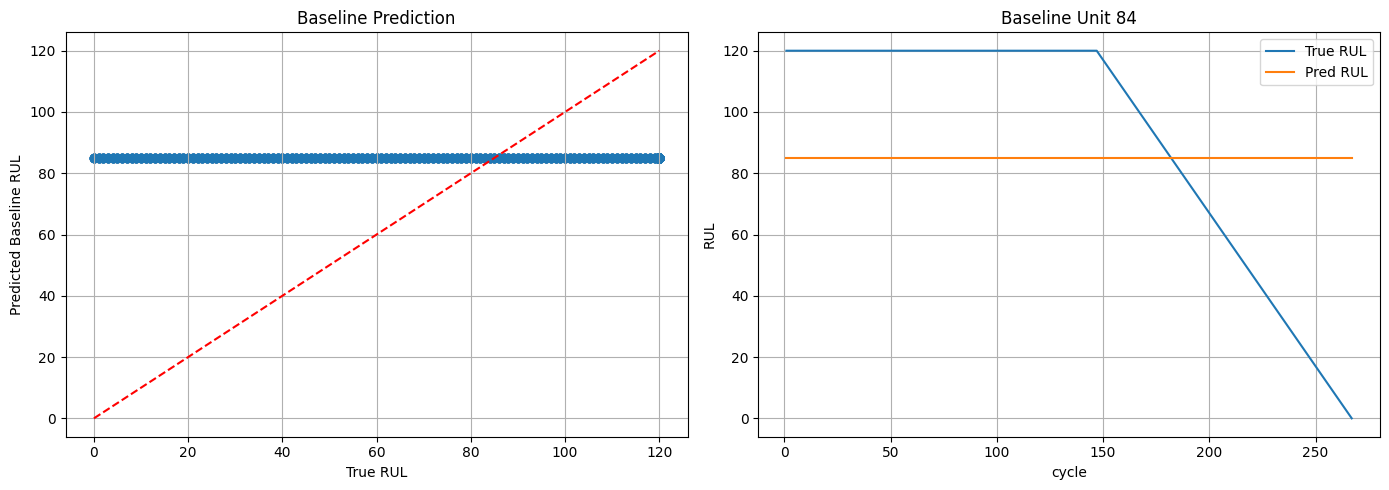

Registered model 'Baseline' already exists. Creating a new version of this model...
Created version '5' of model 'Baseline'.


In [4]:
# Baseline
baseline_pipeline = Pipeline([('model', Baseline())])

baseline_metrics = run_experiment(
    experiment_name=f"CMAPSS_{DATASET}",
    run_name="Baseline",
    pipeline=baseline_pipeline,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    df=test_df, unit=test_units[0],
    features=list(X_train.columns),
    save_path=OUTPUTS_PLOTS/f'03_baseline_{DATASET}.png'
)

## 3 - Linear Regression

First supervised model. Linear regression is sensitive to scale of the features, so we include a StandardScaler.
Good interpretable benchmark before introducing more complex models.

Linear Regression metrics
RMSE_train: 20.144801605625606 RMSE_test: 19.00343158229487
MAE_train : 16.558041516816417 MAE_test : 15.392676346344517
R2_train  : 0.7443518084342629 R2_test  : 0.7733290232842651


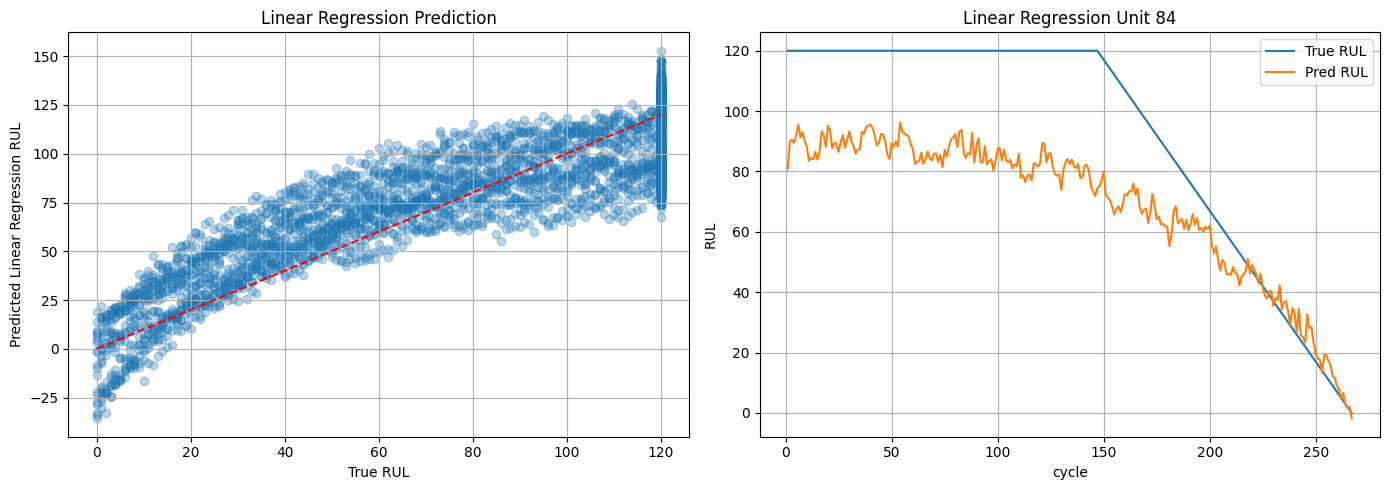

Registered model 'Linear Regression' already exists. Creating a new version of this model...
Created version '5' of model 'Linear Regression'.


In [5]:
# Linear regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  LinearRegression())
])

lr_metrics = run_experiment(
    experiment_name=f"CMAPSS_{DATASET}",
    run_name="Linear Regression",
    pipeline=lr_pipeline,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    df=test_df, unit=test_units[0],
    features=list(X_train.columns),
    save_path=OUTPUTS_PLOTS/f'03_linear_regression_{DATASET}.png'
)

Significant gain over the baseline, the signal is linearly exploitable. The temporal features created earlier clearly contribute to this performance.

## 4 - Random Forest

### Feature selection
Before tuning the model, we train a Random Forest with default parameters and extract feature importances. We will keep the top 15 features in order to reduce dimensionality (although it is not that big here), to improve generalization and to lower training time. RF is not sensitive to feature scale so we don't use any scaler function.

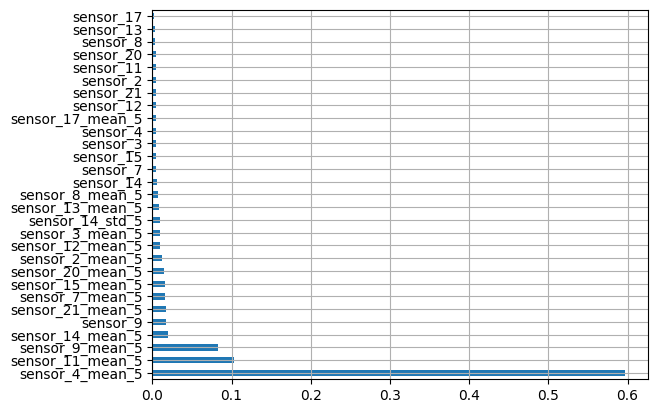

In [6]:
# Random Forest

rf = RandomForestRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
plot_importance(rf, X_train, save_path=OUTPUTS_PLOTS/f'03_importance_rf_{DATASET}.png')

### Random Forest Vanilla

Random Forest metrics
RMSE_train: 5.23104665986259 RMSE_test: 15.902022016129717
MAE_train : 3.5526894511201017 MAE_test : 10.915820638820641
R2_train  : 0.9827617202887478 R2_test  : 0.8412782096705219


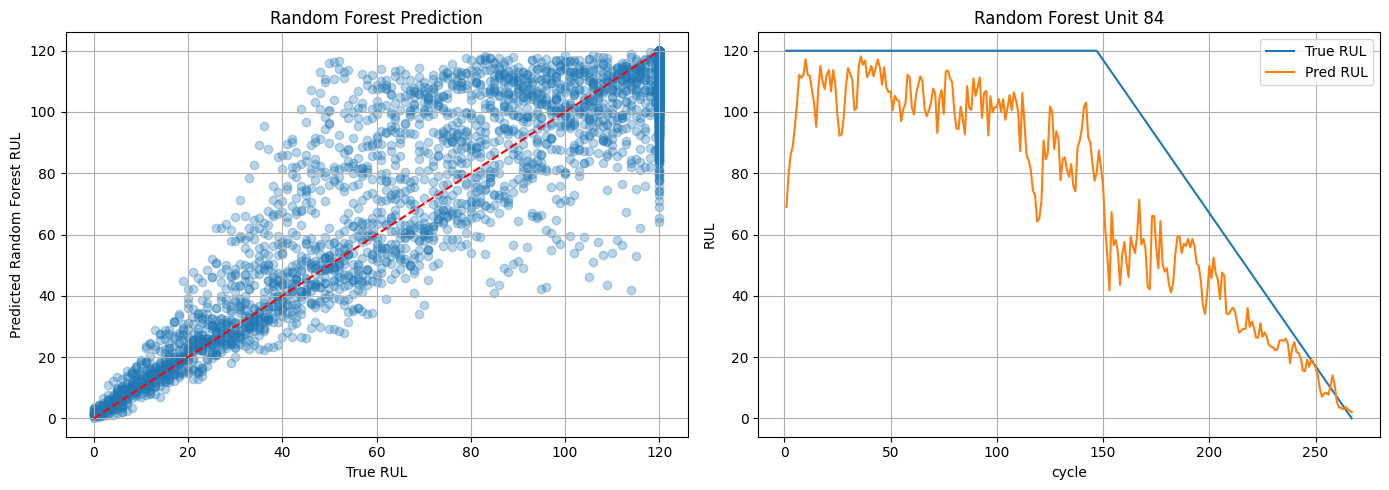

Registered model 'Random Forest' already exists. Creating a new version of this model...
Created version '5' of model 'Random Forest'.


In [7]:
cols_rf = select_top_features(rf, X_train, TOP_FEATURES)
X_train_imp_rf = X_train[cols_rf]
X_test_imp_rf = X_test[cols_rf]

rf_pipeline = Pipeline([('model', RandomForestRegressor(random_state=RANDOM_STATE))])

rf_metrics = run_experiment(
    experiment_name=f"CMAPSS_{DATASET}",
    run_name="Random Forest",
    pipeline=rf_pipeline,
    X_train=X_train_imp_rf, X_test=X_test_imp_rf,
    y_train=y_train, y_test=y_test,
    df=test_df, unit=test_units[0],
    features=list(X_train_imp_rf.columns),
    save_path=OUTPUTS_PLOTS/f'03_random_forest_vanilla_{DATASET}.png'
)

Good results but significant gap between train and test set results (clear overfitting). Model should be tuned.

### Random Forest Tuned

We use GridSearchCV with GroupKFold for cross-validation. Fold by unit to avoid any data leakage.
We optimize n_estimators, max_depth, and min_samples_leaf hyperparameters.

In [ ]:
# Random Forest Tuned

param_grid = {"n_estimators": [100, 200, 300], 
              "max_depth": [None, 10, 20], 
              "min_samples_leaf": [1, 3, 5]}

grid = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                    param_grid,
                    cv=GroupKFold(n_splits=N_SPLITS),
                    scoring="neg_root_mean_squared_error",
                    n_jobs=-1)

grid.fit(X_train_imp_rf, y_train, groups=train_df.loc[X_train_imp_rf.index, 'unit_number'])

print(grid.best_params_)
print(-grid.best_score_)

{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}
17.26271540894658


RF Tuned metrics
RMSE_train: 13.290758818373456 RMSE_test: 15.509101360413057
MAE_train : 9.154018201093395 MAE_test : 10.708866845350844
R2_train  : 0.888720211927899 R2_test  : 0.8490249710990161


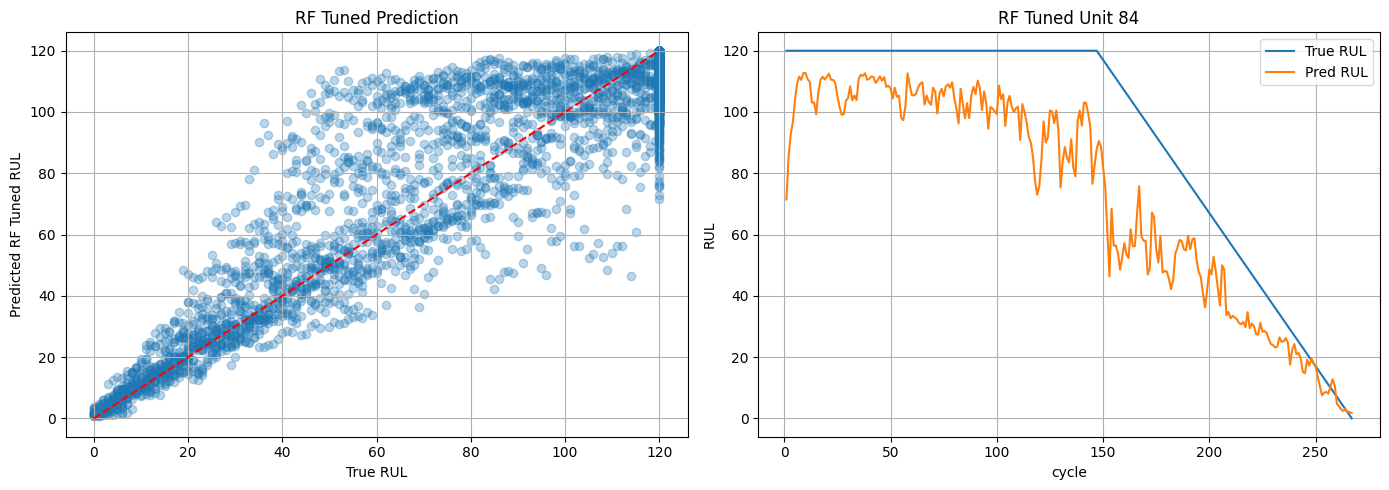

Registered model 'RF Tuned' already exists. Creating a new version of this model...
Created version '5' of model 'RF Tuned'.


In [9]:
best_rf_pipeline = Pipeline([('model', grid.best_estimator_)])

rf_tuned_metrics = run_experiment(
    experiment_name=f"CMAPSS_{DATASET}",
    run_name="RF Tuned",
    pipeline=best_rf_pipeline,
    X_train=X_train_imp_rf, X_test=X_test_imp_rf,
    y_train=y_train, y_test=y_test,
    df=test_df, unit=test_units[0],
    features=list(X_train_imp_rf.columns),
    save_path=OUTPUTS_PLOTS/f'03_random_forest_tuned_{DATASET}.png'
)

Train/test gap narrows significantly, less overfitting and better generalization. Better overall performance.

## 5 - XGBoost

### Feature selection

Similar process: XGBoost computes its own feature importances based on gain rather than Gini impurity.

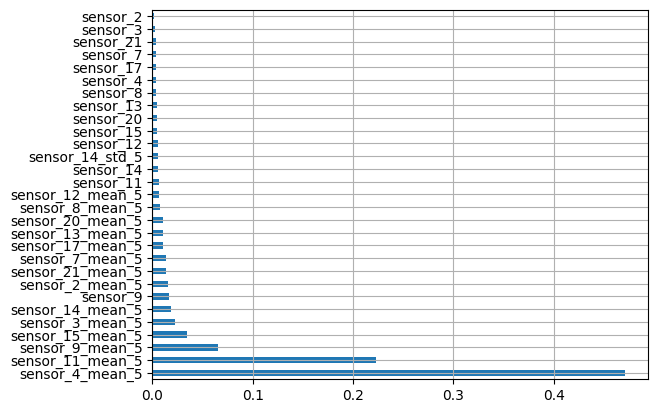

In [10]:
# XGBoost

xgb_ = XGBRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
plot_importance(xgb_, X_train, save_path=OUTPUTS_PLOTS/f'03_importance_xgb_{DATASET}.png')

### XGBoost Vanilla

XGBoost metrics
RMSE_train: 8.712571227823755 RMSE_test: 16.976736869214957
MAE_train : 5.99017333984375 MAE_test : 11.483318328857422
R2_train  : 0.952180027961731 R2_test  : 0.8190993070602417


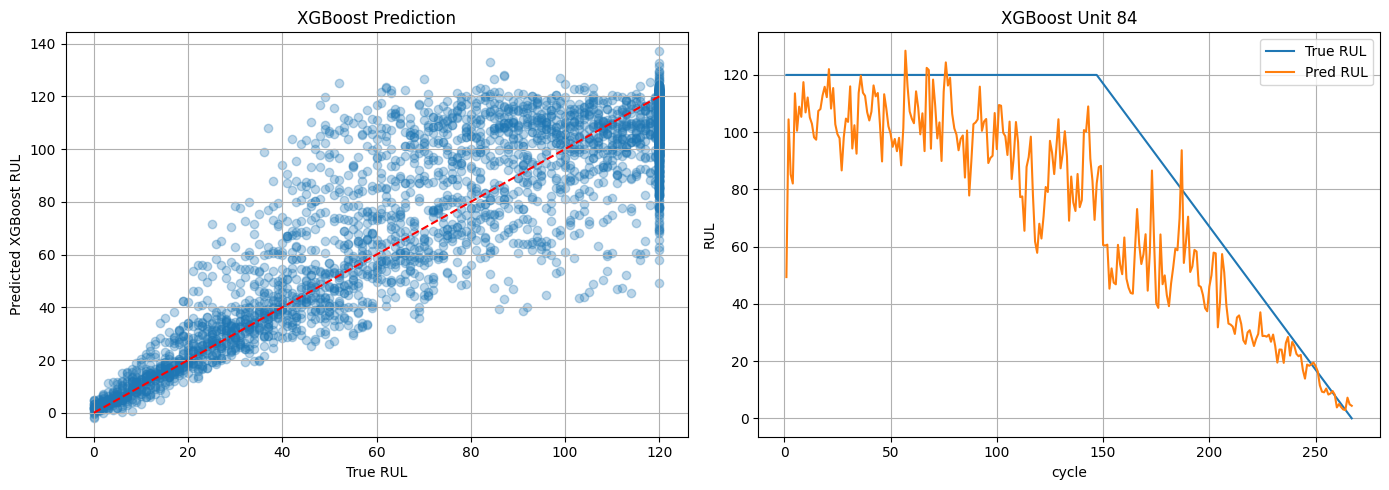

Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '5' of model 'XGBoost'.


In [11]:
cols_xgb = select_top_features(xgb_, X_train, TOP_FEATURES)
X_train_imp_xgb = X_train[cols_xgb]
X_test_imp_xgb = X_test[cols_xgb]

xgb_pipeline = Pipeline([('model', XGBRegressor(random_state=RANDOM_STATE))])

xgb_metrics = run_experiment(
    experiment_name=f"CMAPSS_{DATASET}",
    run_name="XGBoost",
    pipeline=xgb_pipeline,
    X_train=X_train_imp_xgb, X_test=X_test_imp_xgb,
    y_train=y_train, y_test=y_test,
    df=test_df, unit=test_units[0],
    features=list(X_train_imp_xgb.columns),
    save_path=OUTPUTS_PLOTS/f'03_xgb_vanilla_{DATASET}.png'
)

Good results but clear overfitting, we need to optimize the hyperparameters.

### XGBoost Tuned

We optimize n_estimators, max_depth and learning_rate hyperparameters.

In [12]:
# XGBoost Tuned

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
}


grid_xgb = GridSearchCV(
    XGBRegressor(random_state=RANDOM_STATE),
    param_grid_xgb,
    cv=GroupKFold(n_splits=N_SPLITS),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_xgb.fit(X_train_imp_xgb, y_train, groups=train_df.loc[X_train_imp_xgb.index, 'unit_number'])

print("Best params:", grid_xgb.best_params_)
print("Best RMSE (CV):", -grid_xgb.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best RMSE (CV): 17.14988422393799


XGBoost Tuned metrics
RMSE_train: 16.201734021478515 RMSE_test: 15.526852390024244
MAE_train : 11.69968318939209 MAE_test : 11.182486534118652
R2_train  : 0.8346364498138428 R2_test  : 0.8486791849136353


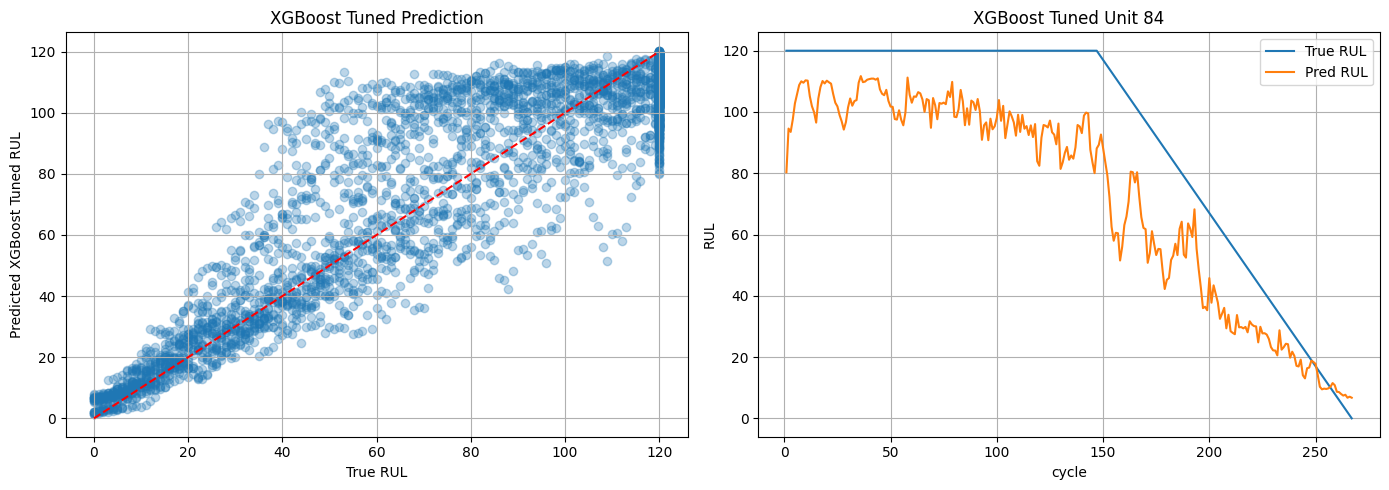

Registered model 'XGBoost Tuned' already exists. Creating a new version of this model...
Created version '5' of model 'XGBoost Tuned'.


In [13]:
best_xgb_pipeline = Pipeline([('model', grid_xgb.best_estimator_)])

xgb_tuned_metrics = run_experiment(
    experiment_name=f"CMAPSS_{DATASET}",
    run_name="XGBoost Tuned",
    pipeline=best_xgb_pipeline,
    X_train=X_train_imp_xgb, X_test=X_test_imp_xgb,
    y_train=y_train, y_test=y_test,
    df=test_df, unit=test_units[0],
    features=list(X_train_imp_xgb.columns),
    save_path=OUTPUTS_PLOTS/f'03_xgb_tuned_{DATASET}.png'
)

Train/test gap is considerably reduced, less overfitting. A low learning rate (0.05) combined with shallow trees (max_depth=3) enforces effective regularization.

## 6 - Saving models and final comparison

In [14]:
joblib.dump(best_rf_pipeline, OUTPUTS_MODELS/f'best_rf_{DATASET}.joblib')
joblib.dump(best_xgb_pipeline, OUTPUTS_MODELS/f'best_xgb_{DATASET}.joblib')
joblib.dump(scaler, OUTPUTS_MODELS/f'scaler_{DATASET}.joblib')
joblib.dump(cols_rf, OUTPUTS_MODELS/f'cols_rf_{DATASET}.joblib')
joblib.dump(cols_xgb, OUTPUTS_MODELS/f'cols_xgb_{DATASET}.joblib')
print('Models saved')

Models saved


In [15]:
results = pd.DataFrame({
    'Baseline':        baseline_metrics,
    'Linear Regression': lr_metrics,
    'Random Forest':   rf_metrics,
    'RF Tuned':        rf_tuned_metrics,
    'XGBoost':         xgb_metrics,
    'XGBoost Tuned':   xgb_tuned_metrics,
}).T.round(3)

results.index.name = 'Model'
print(results.to_string())
results.to_csv(DATA_PROCESSED / f'model_comparison_{DATASET}.csv')

                   rmse_train  rmse_test  mae_train  mae_test  r2_train  r2_test
Model                                                                           
Baseline               39.842     39.919     35.254    35.257     0.000   -0.000
Linear Regression      20.145     19.003     16.558    15.393     0.744    0.773
Random Forest           5.231     15.902      3.553    10.916     0.983    0.841
RF Tuned               13.291     15.509      9.154    10.709     0.889    0.849
XGBoost                 8.713     16.977      5.990    11.483     0.952    0.819
XGBoost Tuned          16.202     15.527     11.700    11.182     0.835    0.849


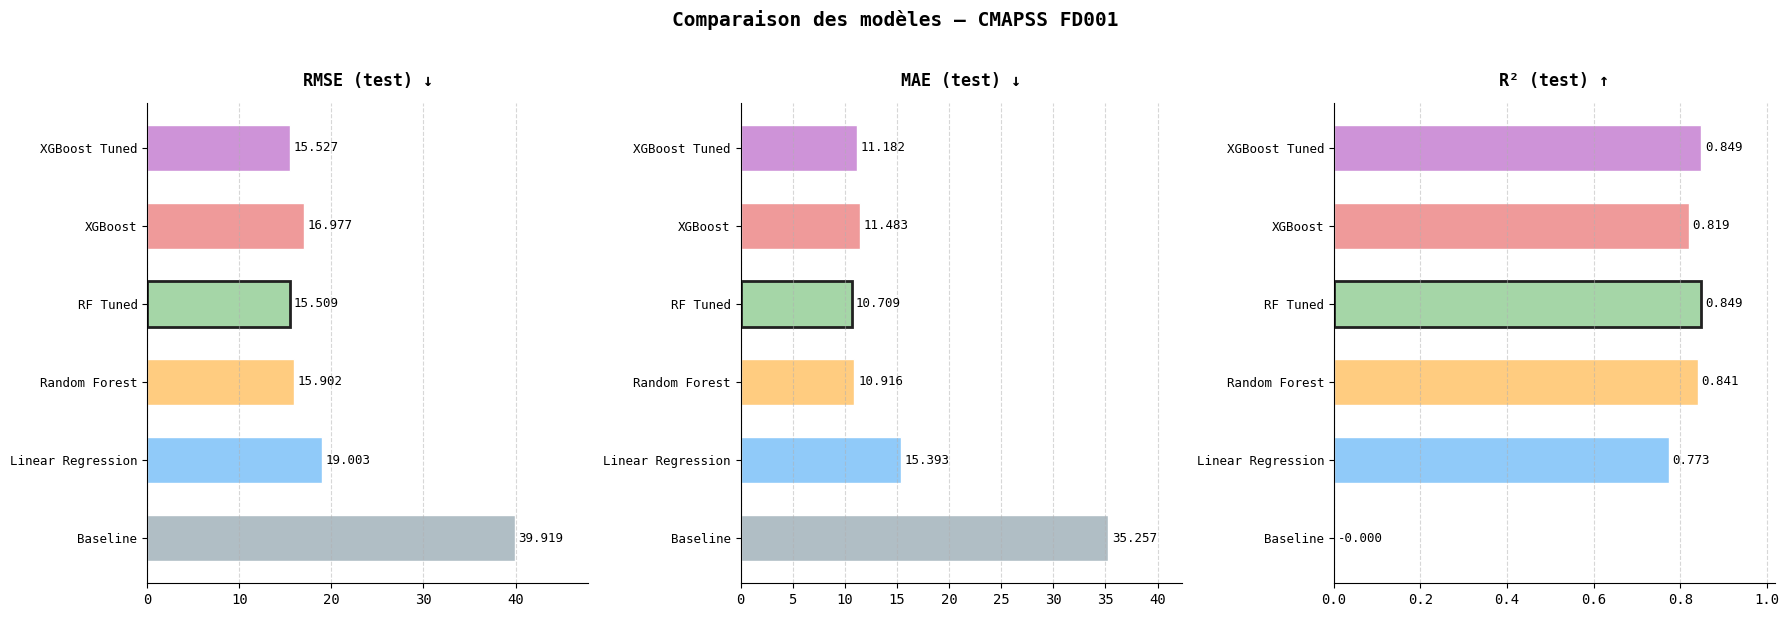

In [16]:
plt.rcParams.update({
    'font.family': 'monospace',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

COLORS = ['#b0bec5', '#90caf9', '#ffcc80', '#a5d6a7', '#ef9a9a', '#ce93d8']
models = results.index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics_test = ['rmse_test', 'mae_test', 'r2_test']
titles       = ['RMSE (test) ↓', 'MAE (test) ↓', 'R² (test) ↑']

for ax, metric, title in zip(axes, metrics_test, titles):
    values = results[metric].values
    bars   = ax.barh(models, values, color=COLORS, edgecolor='white', height=0.6)

    for bar, val in zip(bars, values):
        ax.text(
            bar.get_width() + max(values) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{val:.3f}',
            va='center', ha='left', fontsize=9
        )

    best_idx = values.argmin() if metric != 'r2_test' else values.argmax()
    bars[best_idx].set_edgecolor('#212121')
    bars[best_idx].set_linewidth(2)

    ax.set_title(title, fontsize=12, fontweight='bold', pad=12)
    ax.set_xlim(0, max(values) * 1.2)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', labelsize=9)

plt.suptitle(
    f'Comparaison des modèles — CMAPSS {DATASET}',
    fontsize=14, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'03_model_comparison_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

In [17]:
with mlflow.start_run(run_name="Model Comparison"):
    mlflow.set_tracking_uri((ROOT / 'mlruns').as_uri())
    mlflow.log_artifact(str(DATA_PROCESSED / f'model_comparison_{DATASET}.csv'))

## 7 - Final NASA test on fully-trained dataset with our best model RF Tuned

In [18]:
## NASA Test model

test_nasa = pd.read_csv(DATA_RAW / 'test_FD001.txt', sep=r'\s+', header=None)
test_nasa = test_nasa.dropna(axis=1, how='all')
test_nasa.columns = ['unit_number','time_cycles','setting_1','setting_2','setting_3'] + \
                    [f'sensor_{i}' for i in range(1,22)]

test_nasa = remove_low_variance_features(test_nasa)
test_nasa = add_features(test_nasa)

last_cycles = test_nasa.groupby('unit_number').last().reset_index()

rul_true = pd.read_csv(DATA_RAW / 'RUL_FD001.txt', sep=r'\s+', header=None)
rul_true.columns = ['RUL']
rul_true['RUL'] = rul_true['RUL'].clip(upper=CLIP_RUL)

df_model = pd.read_csv(DATA_PROCESSED / f'train_FD001_features.csv')

X_full = df_model[cols_rf]
y_full = df_model['RUL']

final_rf_pipeline = Pipeline([('model', grid.best_estimator_)])
final_rf_pipeline.fit(X_full, y_full)

X_nasa = last_cycles[cols_rf]
y_pred = final_rf_pipeline.predict(X_nasa)

rmse = np.sqrt(mean_squared_error(rul_true['RUL'], y_pred))
mae  = mean_absolute_error(rul_true['RUL'], y_pred)
r2   = r2_score(rul_true['RUL'], y_pred)

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")

RMSE : 17.336
MAE  : 12.100
R²   : 0.806


In [19]:
joblib.dump(final_rf_pipeline, OUTPUTS_MODELS / f'final_rf_{DATASET}.joblib')

['C:\\Users\\eloua\\OneDrive\\Bureau\\turbofan-rul-prediction\\outputs\\models\\final_rf_FD001.joblib']

In [20]:
with mlflow.start_run(run_name="NASA Test Benchmark"):
    mlflow.set_tracking_uri((ROOT / 'mlruns').as_uri())
    mlflow.set_experiment(f"CMAPSS_{DATASET}")
    mlflow.log_metrics({
        "rmse_nasa": rmse,
        "mae_nasa":  mae,
        "r2_nasa":   r2
    })

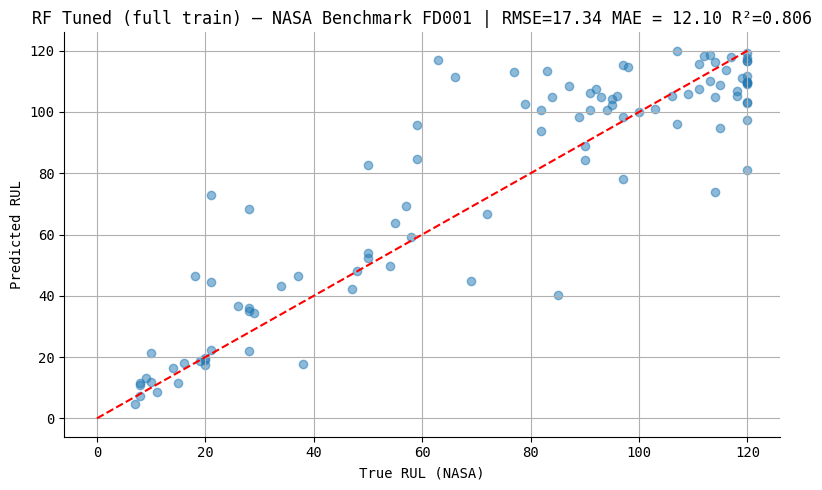

In [21]:
plt.figure(figsize=(8, 5))
plt.scatter(rul_true['RUL'], y_pred, alpha=0.5)
plt.plot([0, rul_true['RUL'].max()], [0, rul_true['RUL'].max()], 'r--')
plt.xlabel('True RUL (NASA)')
plt.ylabel('Predicted RUL')
plt.title(f'RF Tuned (full train) — NASA Benchmark {DATASET} | RMSE={rmse:.2f} MAE = {mae:.2f} R²={r2:.3f}')
plt.grid()
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'03_nasa_benchmark_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()